In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
!unzip stereo_materials.zip

Archive:  stereo_materials.zip
  inflating: l1.png                  
  inflating: l2.png                  
  inflating: l3.png                  
  inflating: r1.png                  
  inflating: r2.png                  
  inflating: r3.png                  


# Loading Images

In [3]:
left = []
right = []

for i in range(1, 4):
  img_left = cv2.imread("l" + str(i) + ".png", 0)
  left.append(img_left)

  img_right = cv2.imread("r" + str(i) + ".png", 0)
  right.append(img_right)

print("Left images: {}".format(len(left)))
print("Right images: {}".format(len(right)))

Left images: 3
Right images: 3


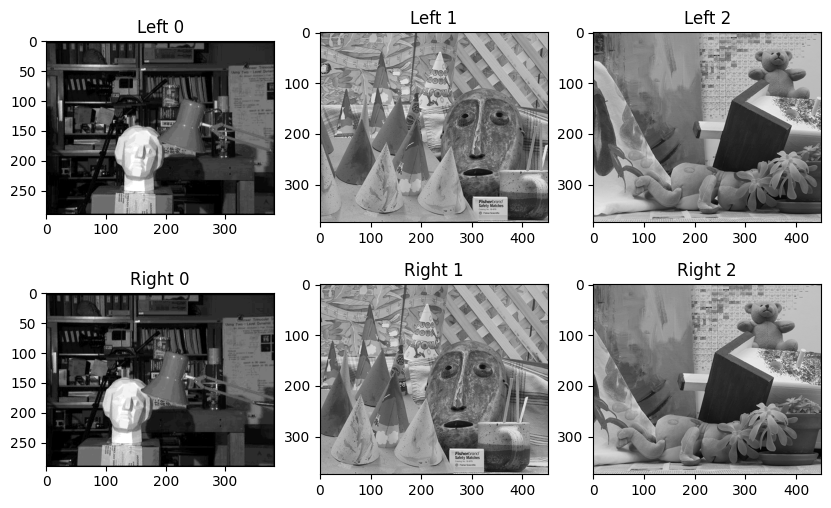

In [4]:
# plot the images
fig, ax = plt.subplots(2, 3, figsize=(10, 6))
for i in range(len(left)):
  ax[0, i].imshow(left[i], cmap="gray")
  ax[0, i].set_title("Left {}".format(i))
  ax[1, i].imshow(right[i], cmap="gray")
  ax[1, i].set_title("Right {}".format(i))
plt.show()

# block matching

In [26]:
SSD = lambda window1, window2: np.sum((window1.astype("float") - window2.astype("float")) ** 2)
SAD = lambda window1, window2: np.sum(np.abs(window1.astype("float") - window2.astype("float")))

In [27]:
def block_matching(img1, img2, window_size, metric):

  height, width = img1.shape
  disparity_map = np.zeros((height, width), np.uint8)
  half_window = window_size // 2

  # Loop through every pixel in the left image
  for y in range(half_window, height - half_window):
    for x in range(half_window, width - half_window):

      # Get the current window
      window = img1[y - half_window: y + half_window + 1, x - half_window: x + half_window + 1]
      # Define the minimum SSD and best disparity
      min_metric = 255 * window_size * window_size
      # min_metric = 1000000000000
      best_disparity = 0

      # compare with each window from the right image
      for xRight in range(half_window, width - half_window):
        # Get the current window from the right image
        current_window = img2[y - half_window: y + half_window + 1, xRight - half_window: xRight + half_window + 1]
        # Calculate the SSD / SAD
        m = metric(window, current_window)
        # if the SSD / SAD is smaller than the minimum metric update the minimum mertric and the best disparity
        if m < min_metric:
          min_metric = m
          best_disparity = np.abs(x-xRight)

      # Update the disparity map
      disparity_map[y, x] = best_disparity

  return disparity_map

Using SSD

In [28]:
win_size = [1, 5, 9]

KeyboardInterrupt: ignored

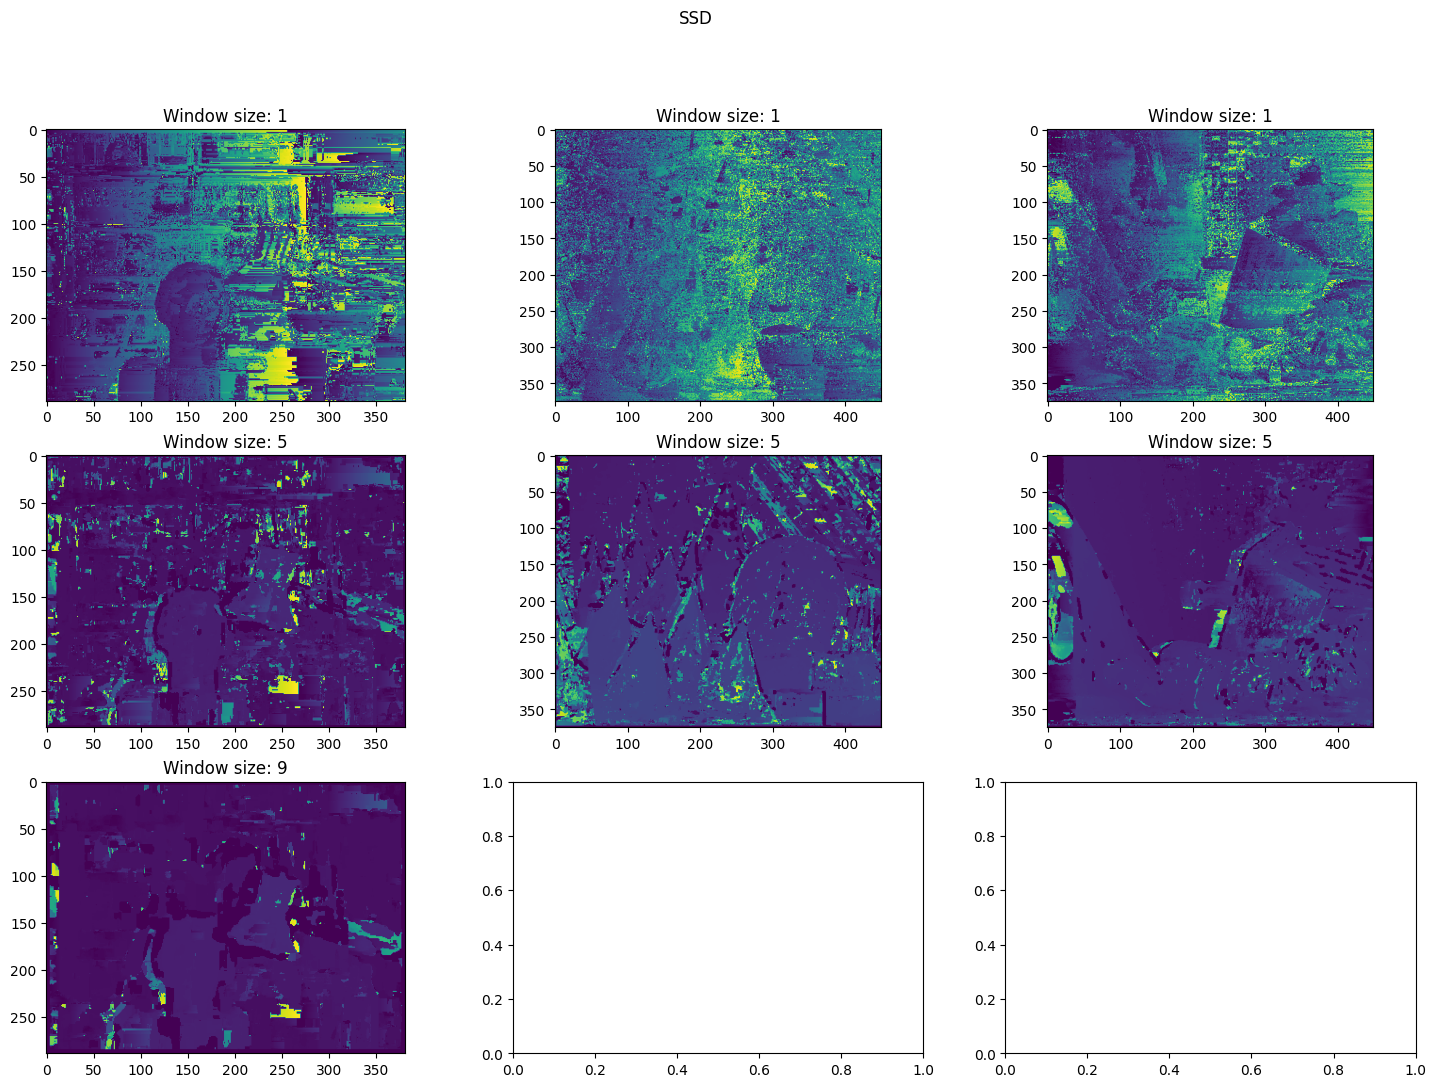

In [ ]:
fig , ax = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("SSD")
for i, win in enumerate(win_size):
    for j in range(len(left)):
        ax[i, j].imshow(block_matching(left[j], right[j], window_size=win, metric=SSD))
        ax[i, j].set_title("Window size: {}".format(win))
plt.show()

Using SAD

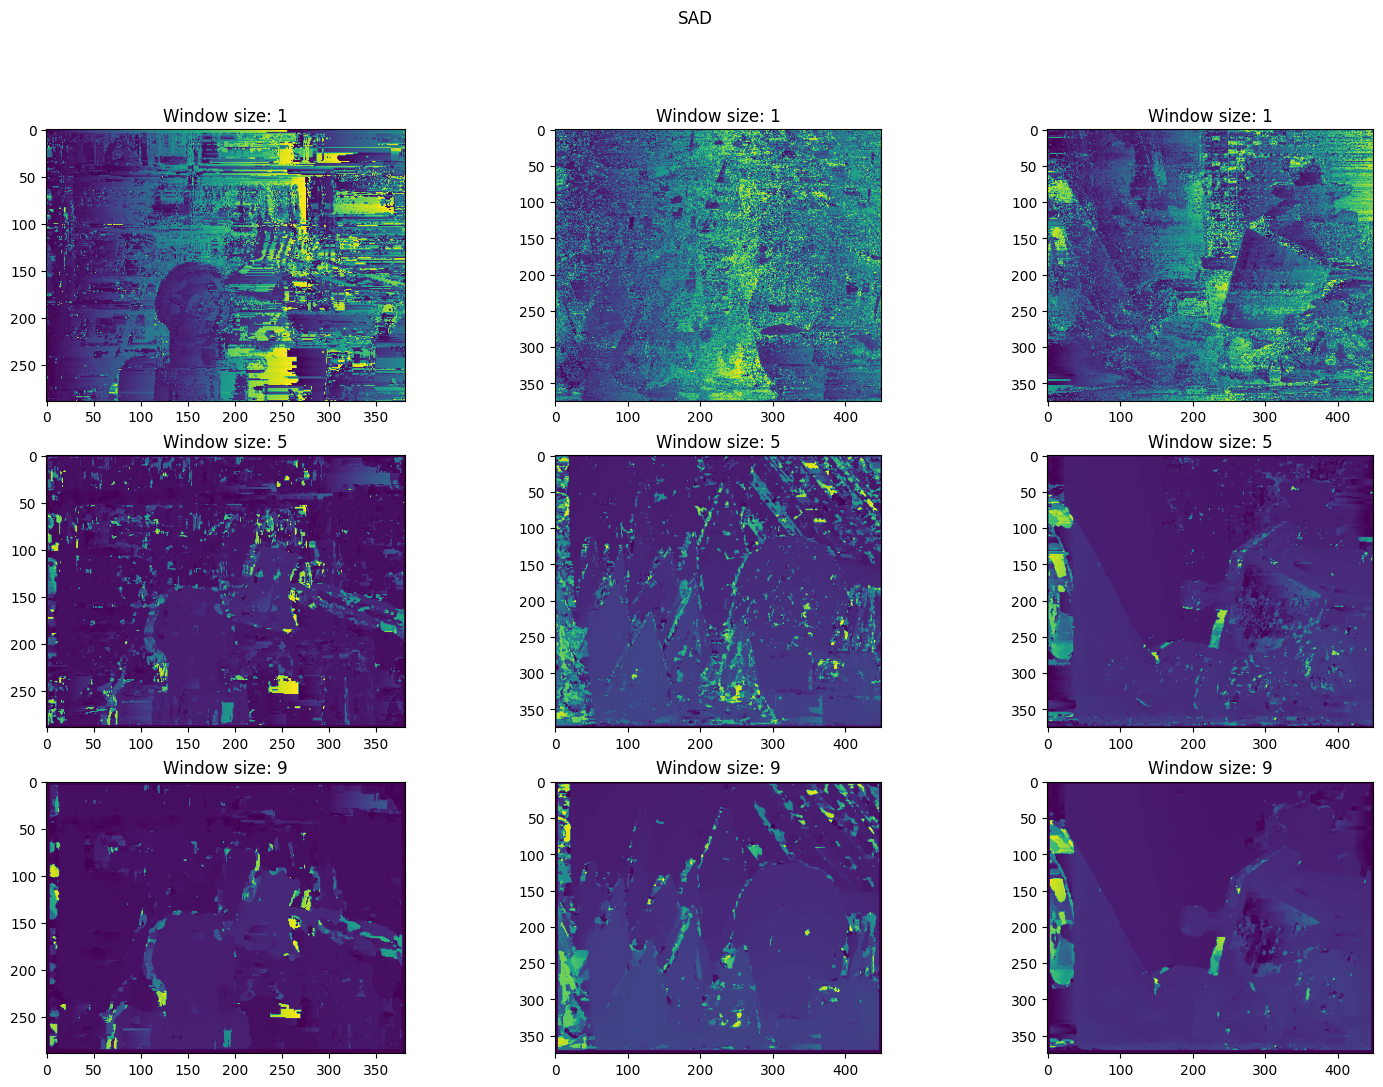

In [29]:
fig , ax = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle("SAD")
for i, win in enumerate(win_size):
  for j in range(len(left)):
    ax[i, j].imshow(block_matching(left[j], right[j], window_size=win, metric=SAD))
    ax[i, j].set_title("Window size: {}".format(win))
plt.show()

# Dynamic Programming

In [5]:
sigma = 2
c0 = 1
DynamicCost = lambda pixelL, pixelR: ((pixelL.astype('float') - pixelR.astype('float'))**2 // sigma**2)

In [21]:
from random import randint

def dp_Stereo(imgLeft, imgRight):

  rows, columns = imgLeft.shape
  # Define the disparity maps
  disparity = np.zeros((rows, columns), dtype='float16')

  # Define matrix for plotting optimal path
  randScanline = randint(0, rows)
  optimalPath = np.zeros((columns, columns), dtype='uint8')

  # Computing Forward Pass to calculate costs
  for scanline in range(rows):
    # Define the cost matrix
    costs = np.full((columns, columns), np.inf)
    costs[0][0] = DynamicCost(imgLeft[scanline][0], imgRight[scanline][0])

    # Computing optimal cost
    for i in range(1, columns):
      for j in range (1, columns):
        #if i == 0 and j == 0 :
         # continue
        costs[i][j] = min(costs[i-1][j-1] + DynamicCost(imgLeft[scanline][i], imgRight[scanline][j]), costs[i-1][j] + c0, costs[i][j-1] + c0)


    # backtracking
    i = columns-1
    j = columns-1
    while (i > 0 and j > 0):
      # Plot optimal path if scanline = randomly selected
      if scanline == randScanline :
        optimalPath[i][j] = 255


      minCost = np.argmin([costs[i-1][j-1], costs[i-1][j], costs[i][j-1]])
      if minCost == 0 :
        disparity[scanline][i] = np.abs(i-j)
        i-=1
        j-=1

      elif minCost == 1 :
        i-=1

      else :
        j-=1

      '''
      # its a match if its equal to the diagonal cost
      if costs[i][j] == costs[i-1][j-1]:
        disparity[scanline][i] = np.abs(i-j)
        i-=1
        j-=1

      # skipping a pixel in left image
      elif costs[i][j] == costs[i-1][j]:
        i-=1

      # skipping a pixel in right image
      elif costs[i][j] == costs[i][j-1]:
        j-=1
      '''

  return disparity, optimalPath

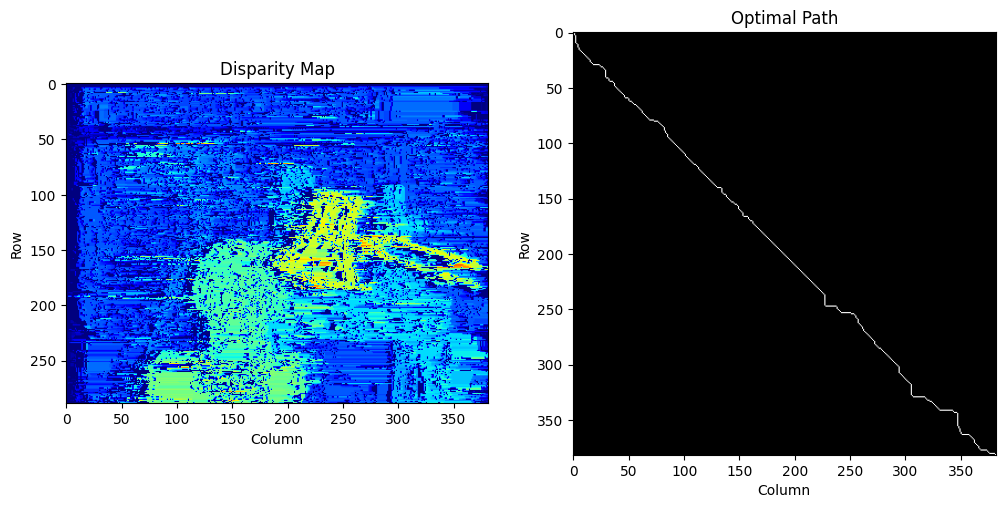

In [22]:
def visualize_results(disparity, optimalPath):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Disparity Map
    ax[0].imshow(disparity, cmap='jet')
    ax[0].set_title('Disparity Map')
    ax[0].set_xlabel('Column')
    ax[0].set_ylabel('Row')

    # Plot Optimal Path
    ax[1].imshow(optimalPath, cmap='gray')
    ax[1].set_title('Optimal Path')
    ax[1].set_xlabel('Column')
    ax[1].set_ylabel('Row')

    plt.show()

disparity, optimalPath = dp_Stereo(left[0],right[0])
visualize_results(disparity, optimalPath)

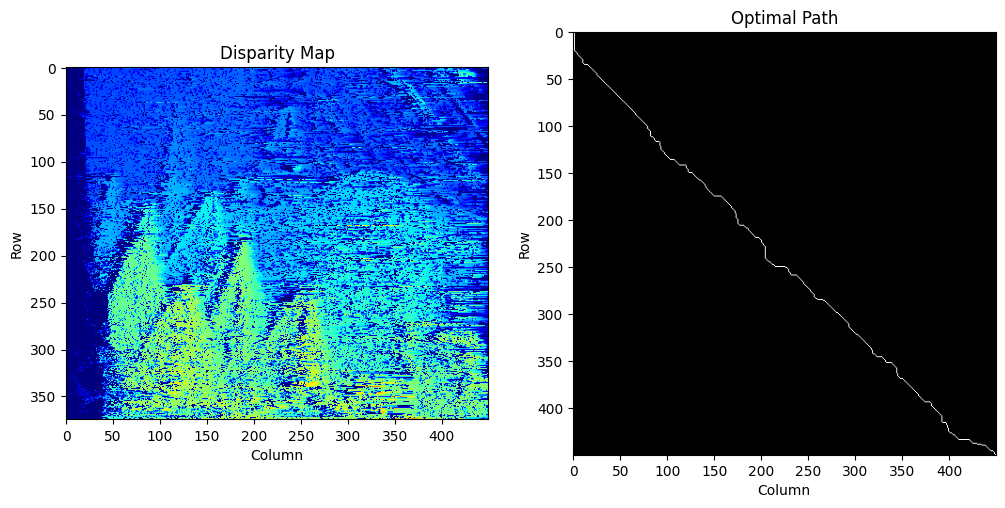

In [23]:
disparity, optimalPath = dp_Stereo(left[1],right[1])
visualize_results(disparity, optimalPath)

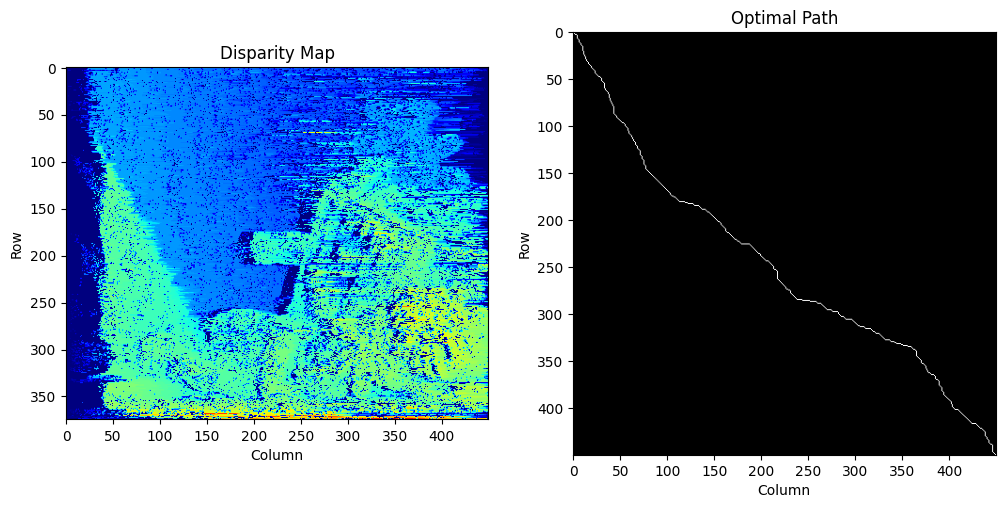

In [24]:
disparity, optimalPath = dp_Stereo(left[2],right[2])
visualize_results(disparity, optimalPath)